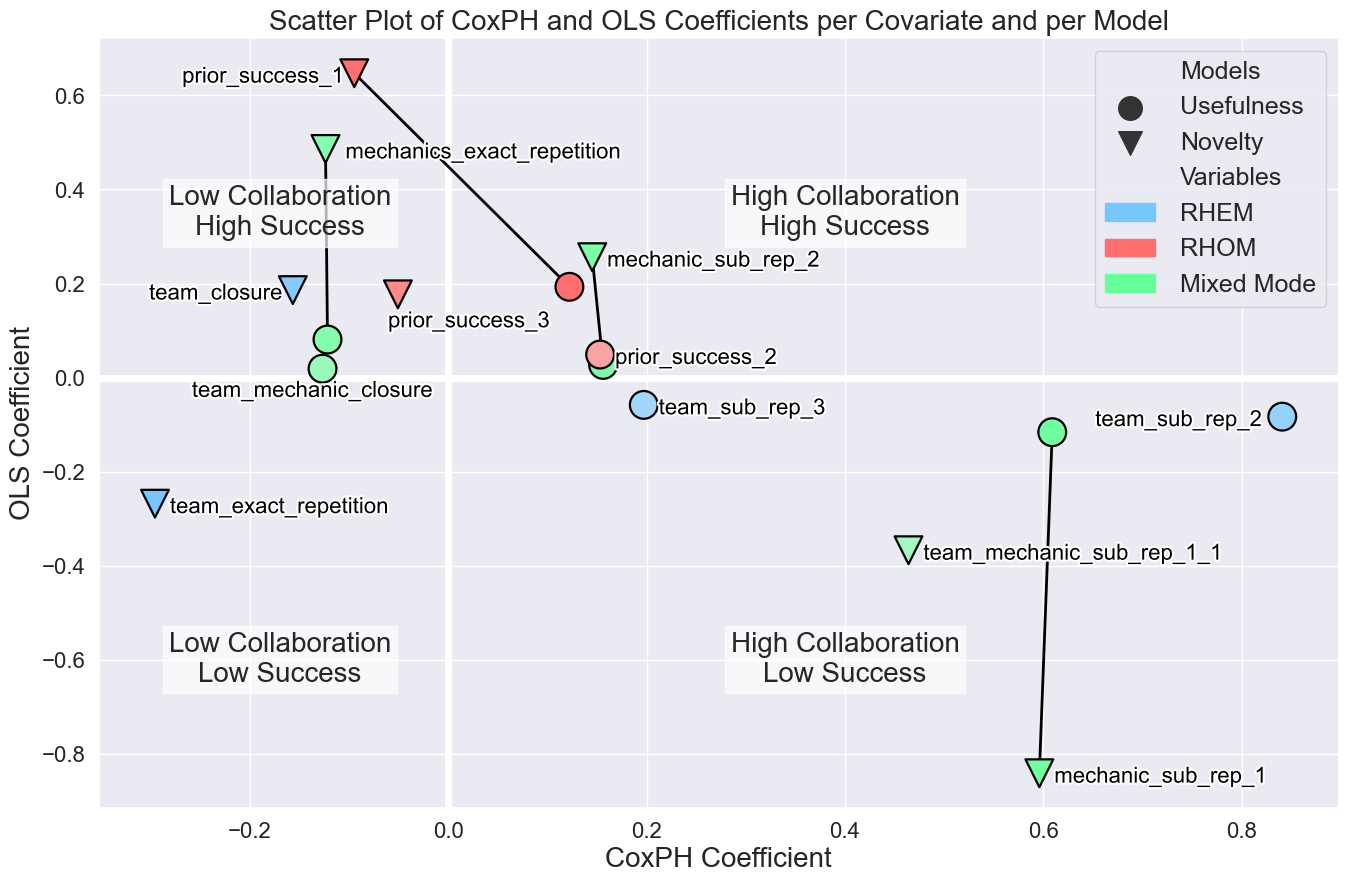

In [49]:
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import matplotlib.patheffects as patheffects
import matplotlib.lines as mlines


# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load data from CSV
csv_file = 'h2.csv'  # Replace with your actual CSV file path
df = pd.read_csv(csv_file)

# Define a function to filter significant values


def filter_significant(coefficients, p_values, significance_threshold=0.1):
    return [coeff if p < significance_threshold else None for coeff, p in zip(coefficients, p_values)]


# Apply the filter function to the coefficients and p-values
significant_coxph_novelty = filter_significant(
    df["CoxPH_Coefficient_novelty"], df["CoxPH_PValue_novelty"])
significant_ols_novelty = filter_significant(
    df["OLS_Coefficient_novelty"], df["OLS_PValue_novelty"])
significant_coxph_usefulness = filter_significant(
    df["CoxPH_Coefficient_usefulness"], df["CoxPH_PValue_usefulness"])
significant_ols_usefulness = filter_significant(
    df["OLS_Coefficient_usefulness"], df["OLS_PValue_usefulness"])

# Combine the data for Novelty and Usefulness
combined_data = pd.DataFrame({
    "Variable": list(df["Variable"]) * 2,
    "Model": ["Novelty"] * len(df) + ["Usefulness"] * len(df),
    "CoxPH": significant_coxph_novelty + significant_coxph_usefulness,
    "OLS": significant_ols_novelty + significant_ols_usefulness,
})
combined_data = combined_data[~combined_data[[
    "CoxPH", "OLS"]].isna().sum(1).astype(bool)]
# Calculate distances from origin and transform them to increase differences quickly
combined_data['Distance'] = np.sqrt(
    combined_data["CoxPH"]**2 + combined_data["OLS"]**2)
# Adjust the transformation as needed
combined_data['Size'] = combined_data['Distance']

color_sets = {
    'colorset1': ['team_size',
                  'team_exact_repetition',
                  'team_closure',
                  'team_sub_rep_2',
                  'team_sub_rep_3'
                  ],
    'colorset2': ['prior_success_1',
                  'prior_success_3',
                  'prior_success_2',],
    'colorset3': ['mechanic_size',
                  'mechanic_sub_rep_1',
                  'mechanic_sub_rep_2',
                  'mechanics_exact_repetition',
                  'mechanic_sub_rep_3',
                  'team_mechanic_closure',
                  'team_mechanic_sub_rep_1_1',]
}
palette1 = sns.light_palette("#66C2FF", len(
    color_sets['colorset1'])*2, reverse=True)
palette2 = sns.light_palette("#FF6F6F", len(
    color_sets['colorset2'])*2, reverse=True)
palette3 = sns.light_palette("#66FF99", len(
    color_sets['colorset3'])*2, reverse=True)

color_mapping = {var: color for var, color in zip(
    color_sets['colorset1'], palette1)}
color_mapping.update(
    {var: color for var, color in zip(color_sets['colorset2'], palette2)})
color_mapping.update(
    {var: color for var, color in zip(color_sets['colorset3'], palette3)})

# Set theme for the plot
sns.set_theme(style="darkgrid")

# Create the scatter plot
plt.figure(figsize=(16, 10))
# Add dashed lines at zero using the grid
plt.axhline(0, color='white', linewidth=5, zorder=0)
plt.axvline(0, color='white', linewidth=5, zorder=0)

# Plot the lines connecting pairs with consistent line width and style
for var in combined_data['Variable'].unique():
    subset = combined_data[combined_data["Variable"] == var]
    sns.lineplot(data=subset, x="CoxPH", y="OLS",
                 color="black", linewidth=2, zorder=1)

    # Calculate distances from origin
    distances = np.sqrt(subset["CoxPH"]**2 + subset["OLS"]**2)
    farthest_point_idx = distances.idxmax()

    # Determine the position of the label
    x_pos = subset["CoxPH"].loc[farthest_point_idx]
    y_pos = subset["OLS"].loc[farthest_point_idx]

    # Plot text with different rotations and paddings based on quadrant
    if x_pos > 0 and y_pos > 0:
        # Top Right quadrant
        rotation_angle = 0
        horizontal_align = 'left'
        x_pad = 0.015
    elif x_pos > 0 and y_pos < 0:
        # Bottom Right quadrant
        rotation_angle = 0
        horizontal_align = 'left'
        x_pad = 0.015
    elif x_pos < 0 and y_pos < 0:
        # Bottom Left quadrant
        rotation_angle = 0
        horizontal_align = 'left'
        x_pad = 0.015
    else:
        # Top Left quadrant
        rotation_angle = -0
        horizontal_align = 'right'
        x_pad = -0.01
    cor_y = 0
    if (var in [ "prior_success_3",]):
        horizontal_align = 'left'
        cor_y = -0.05
    if (var in ["team_mechanic_closure"]):
        cor_y = -0.04
        horizontal_align = 'center'
    if (var in ["mechanics_exact_repetition"]):
        x_pad = +0.02
        horizontal_align = 'left'
    if (var in ["team_sub_rep_2"]):
        x_pad = -0.02
        horizontal_align = 'right'

    plt.text(x_pos + x_pad, y_pos - 0.02+cor_y, var, horizontalalignment=horizontal_align, fontsize=16, color="black",
             path_effects=[patheffects.withStroke(linewidth=3, foreground='white')], zorder=3, rotation=rotation_angle)

# Plot the scatter points with different markers for Novelty and Usefulness
scatter = sns.scatterplot(data=combined_data, x="CoxPH", y="OLS", hue="Variable", style="Model", size="Size",
                          sizes=(400, 400), markers={"Novelty": "v", "Usefulness": "o"},
                          edgecolor="black", palette=color_mapping, legend="brief", zorder=2)

# Add text for each quadrant
plt.text(0.4, .35, "High Collaboration\nHigh Success",
         horizontalalignment='center', verticalalignment='center', fontsize=20, bbox=dict(facecolor='white', alpha=0.7))
plt.text(-0.17, 0.35, "Low Collaboration\nHigh Success",
         horizontalalignment='center', verticalalignment='center', fontsize=20, bbox=dict(facecolor='white', alpha=0.7))
plt.text(-0.17, -0.6, "Low Collaboration\nLow Success",
         horizontalalignment='center', verticalalignment='center', fontsize=20, bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.4, -0.6, "High Collaboration\nLow Success",
         horizontalalignment='center', verticalalignment='center', fontsize=20, bbox=dict(facecolor='white', alpha=0.7))

# Customize the plot
plt.title("Scatter Plot of CoxPH and OLS Coefficients per Covariate and per Model",
          fontsize=20,)
plt.xlabel("CoxPH Coefficient", fontsize=20)
plt.ylabel("OLS Coefficient", fontsize=20)

from matplotlib.legend_handler import HandlerPathCollection
class HandlerScaledPathCollection(HandlerPathCollection):
    def __init__(self, factor, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        handles = super().create_artists(legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans)
        for handle in handles:
            handle.set_sizes([size * self.factor for size in handle.get_sizes()])
        return handles

# Example handles and labels
handles, labels = scatter.get_legend_handles_labels()
empty = mlines.Line2D([], [], color='none')
model_handles = [empty,handles[-1], handles[-2],empty,
                 mpatches.Patch(color=palette1[1]), mpatches.Patch(color=palette2[0]), mpatches.Patch(color=palette3[0])]
model_labels = ["Models",labels[-1], labels[-2], "Variables","RHEM", "RHOM", "Mixed Mode"]

# Factor by which to scale the handles
scale_factor = 8

# Create the legend with scaled handles
plt.legend(model_handles, model_labels, handler_map={
    handles[-1]: HandlerScaledPathCollection(factor=scale_factor),
    handles[-2]: HandlerScaledPathCollection(factor=scale_factor),
},loc='upper right', fontsize='18',handletextpad=1)
# Move the legend to the top right inside the plot
#plt.legend(model_handles, model_labels, loc='upper right', fontsize='20')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("h2.png", dpi=200, bbox_inches='tight')
plt.show()